CMPE 258 Assignment #2 
1. Author: Tu Lan 011495497 tu.lan@sjsu.edu
2. Date: 02/15/2018
3. Tips: Before running the code, please change the Directories to yours, especially the directory of datasets

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# basic libraries
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

# To plot pretty figures
%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.style.use('seaborn')

# Directories
PROJECT_ROOT_DIR = '/home/tulan/PycharmProjects/Google/Machine_Learning/CMPE258/HW2'
DATA_DIR = '/home/tulan/PycharmProjects/Google/Machine_Learning/CMPE258/data'

# Where to save the figures
IMAGE_FOLD = 'images'
IMAGE_DIR = os.path.join(PROJECT_ROOT_DIR, IMAGE_FOLD)

def save_fig(fig_id, tight_layout=True):
    if not os.path.exists(IMAGE_DIR):
        os.makedirs(IMAGE_DIR)
    path = os.path.join(IMAGE_DIR, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

Question 1:  Polynomial regression / overfitting / regularization


In [277]:
df1 = pd.read_csv(DATA_DIR + '/ex2data1.csv')
df1.head()

,x,y
0,0.259901,1.291599
1,0.645010,1.015651
2,0.041568,0.187619
3,0.646758,0.271723
4,0.904388,-0.822251


In [278]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 2 columns):
x    30 non-null float64
y    30 non-null float64
dtypes: float64(2)
memory usage: 560.0 bytes


In [279]:
X = df1['x'].values.reshape(-1, 1)
y = df1['y'].values.reshape(-1, 1)
X.shape, y.shape

((30, 1), (30, 1))

Saving figure scatter plot Q1


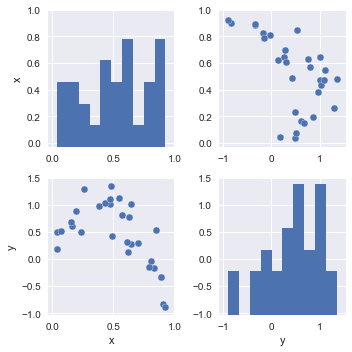

In [280]:
sns.pairplot(df1)
save_fig('scatter plot Q1')

1.1: Fit the data using linear (1st order) regression model (matrix form, gradient descent method).


In [224]:
class LR_Matrix(object):
    def __init__(self, alpha=0.01, n_iter=10):
        self.alpha = alpha
        self.n_iter = n_iter

    def scale(self, X):
        self.sc_X = StandardScaler()
        self.X_std = self.sc_X.fit_transform(X)
        self.X_std1 = np.c_[np.ones((X.shape[0], 1)), self.X_std]
        return self

    def fit(self, X, y):
        self.X = X
        self.y = y
        self.scale(X)
        self.weights = np.zeros((X.shape[1] + 1, 1))
        self.cost = []
        self.m = X.shape[0]

        for i in range(self.n_iter):

            # Batch Gradient Descent Using Matrix
            gradients = 2 / self.m * self.X_std1.T.dot(self.X_std1.dot(self.weights) - self.y)
            self.weights = self.weights - self.alpha * gradients

            y_predict = self.predict()
            errors = (y_predict - self.y)
            cost_ = ((errors ** 2).sum() / self.m) ** 0.5
            self.cost.append(cost_)
            if (i+1) % 10 == 0:
                print('n_iter: %d, RMSE: %f' % (i+1, cost_))
            
        return self

    def predict(self):
        predict_std = self.X_std1.dot(self.weights)
        return predict_std

    def plotFinal(self, xlabel='X', ylabel='y', title='Linear Regression'):
        plt.plot(self.X, self.y, "b.")
        plt.plot(self.X, self.predict(), "g-")
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        # plt.axis([min(self.X) - 1, max(self.X) + 1, min(self.y) - 1, max(self.y) + 1])


In [225]:
lr_11 = LR_Matrix(alpha=0.1, n_iter=100)
lr_11.fit(X, y)

n_iter: 10, RMSE: 0.479994
n_iter: 20, RMSE: 0.476284
n_iter: 30, RMSE: 0.476241
n_iter: 40, RMSE: 0.476240
n_iter: 50, RMSE: 0.476240
n_iter: 60, RMSE: 0.476240
n_iter: 70, RMSE: 0.476240
n_iter: 80, RMSE: 0.476240
n_iter: 90, RMSE: 0.476240
n_iter: 100, RMSE: 0.476240


In [226]:
print('Final RMSE: %f' % lr_11.cost[-1])
print('Final Weights:\n', lr_11.weights)

Final RMSE: 0.476240
Final Weights:
 [[ 0.45269151]
 [-0.32621936]]


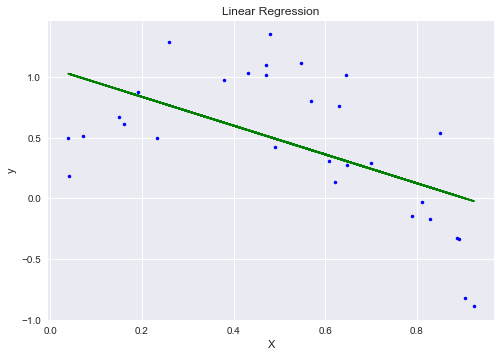

In [227]:
# plot
lr_11.plotFinal()

1.2: Fit the data using 2nd order polynomial regression model (matrix form, gradient descent method).


In [2]:
class LR_Poly_Matrix(object):
    def __init__(self, alpha=0.01, n_iter=10, order=1, printStep=10, normalize=True):
        self.alpha = alpha
        self.n_iter = n_iter
        self.order = order
        self.printStep = printStep
        self.normalize = normalize
        self.sc_X = StandardScaler()
        self.poly_features = PolynomialFeatures(degree=self.order, include_bias=False)

    def scale(self, X):
        if self.normalize == True:
            X_std = self.sc_X.fit_transform(X)
            X_std1 = np.c_[np.ones((X.shape[0], 1)), X_std]   
        else:
            X_std1 = np.c_[np.ones((X.shape[0], 1)), X]
        return X_std1
    
    # Method 1: Direct Calculate poly features
    def polyX(self, X):  
        X_poly = X
        for i in range(self.order - 1):
            temp = X ** (i+2)
            X_poly = np.concatenate((X_poly, temp), axis=1)
        return X_poly
    
    # Method 2: use sklearn library
    # def polyX(self, X):
    #     X_poly = self.poly_features.fit_transform(X)
    #     return X_poly

    def fit(self, X, y):
        self.X = X
        self.y = y
        if self.order == 1:
            self.X_std1 = self.scale(X)
        else:
            self.X_std1 = self.scale(self.polyX(X))
        self.weights = np.zeros((self.X_std1.shape[1], 1))
        self.cost = []
        self.m = X.shape[0]

        for i in range(self.n_iter):

            # Batch Gradient Descent Using Matrix
            gradients = 2 / self.m * self.X_std1.T.dot(self.X_std1.dot(self.weights) - self.y)
            self.weights = self.weights - self.alpha * gradients

            y_predict = self.predict(self.X_std1)
            errors = (y_predict - self.y)
            cost_ = ((errors ** 2).sum() / self.m) ** 0.5
            self.cost.append(cost_)
            if (i+1) % self.printStep == 0:
                print('n_iter: %d, RMSE: %f' % (i+1, cost_))
            
        return self

    def predict(self, X):
        predict_std = X.dot(self.weights)
        return predict_std

    def plotFinal(self, xlabel='X', ylabel='y', title='Polynomial Linear Regression'):
        plt.plot(self.X, self.y, "b.")
        if self.order == 1:
            plt.plot(self.X, self.predict(self.X_std1), "g-")
        else:         
            X_new = np.linspace(min(self.X), max(self.X), self.m).reshape(-1, 1)
            X_new_poly = self.polyX(X_new)
            X_new_std = self.sc_X.transform(X_new_poly)
            X_final = np.c_[np.ones((X_new.shape[0], 1)), X_new_std]
            y_new = self.predict(X_final)
            plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)

In [292]:
lr_12 = LR_Poly_Matrix(alpha=0.3, n_iter=500, order=2, printStep=50, normalize=True)
lr_12.fit(X, y)

n_iter: 50, RMSE: 0.312513
n_iter: 100, RMSE: 0.289648
n_iter: 150, RMSE: 0.286262
n_iter: 200, RMSE: 0.285779
n_iter: 250, RMSE: 0.285711
n_iter: 300, RMSE: 0.285701
n_iter: 350, RMSE: 0.285700
n_iter: 400, RMSE: 0.285699
n_iter: 450, RMSE: 0.285699
n_iter: 500, RMSE: 0.285699


In [293]:
print('Final RMSE: %f' % lr_12.cost[-1])
print('Final Weights:\n', lr_12.weights)

Final RMSE: 0.285699
Final Weights:
 [[ 0.45269151]
 [ 1.13728181]
 [-1.51228601]]


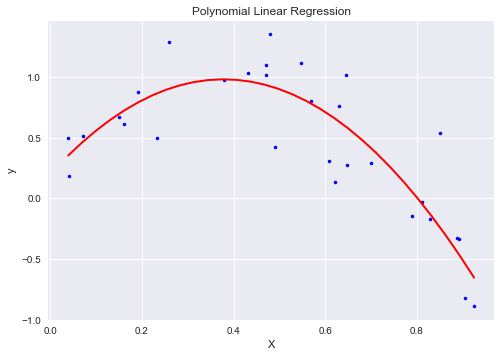

In [294]:
lr_12.plotFinal()

1.3 Fit the data using 4th order polynomial regression model (matrix form, gradient descent method).


In [297]:
lr_13 = LR_Poly_Matrix(alpha=0.2, n_iter=5000, order=4, printStep=500, normalize=True)
lr_13.fit(X, y)

n_iter: 500, RMSE: 0.290418
n_iter: 1000, RMSE: 0.287421
n_iter: 1500, RMSE: 0.286337
n_iter: 2000, RMSE: 0.285944
n_iter: 2500, RMSE: 0.285799
n_iter: 3000, RMSE: 0.285744
n_iter: 3500, RMSE: 0.285720
n_iter: 4000, RMSE: 0.285708
n_iter: 4500, RMSE: 0.285699
n_iter: 5000, RMSE: 0.285693


In [298]:
print('Final RMSE: %f' % lr_13.cost[-1])
print('Final Weights:\n', lr_13.weights)

Final RMSE: 0.285693
Final Weights:
 [[ 0.45269151]
 [ 1.13265261]
 [-1.26609527]
 [-0.61335013]
 [ 0.37811313]]


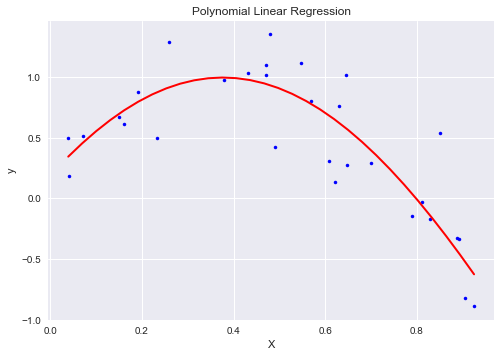

In [299]:
lr_13.plotFinal()

1.4 Fit the data using 16th order polynomial regression model (matrix form, gradient descent method).


In [301]:
lr_14 = LR_Poly_Matrix(alpha=0.06, n_iter=20000, order=16, printStep=2000, normalize=True)
lr_14.fit(X, y)

n_iter: 2000, RMSE: 0.265486
n_iter: 4000, RMSE: 0.263391
n_iter: 6000, RMSE: 0.263160
n_iter: 8000, RMSE: 0.263025
n_iter: 10000, RMSE: 0.262919
n_iter: 12000, RMSE: 0.262834
n_iter: 14000, RMSE: 0.262765
n_iter: 16000, RMSE: 0.262711
n_iter: 18000, RMSE: 0.262667
n_iter: 20000, RMSE: 0.262631


In [302]:
print('Final RMSE: %f' % lr_14.cost[-1])
print('Final Weights:\n', lr_14.weights)

Final RMSE: 0.262631
Final Weights:
 [[ 0.45269151]
 [ 0.92048574]
 [-0.26512951]
 [-0.89627044]
 [-0.84314493]
 [-0.47899015]
 [-0.06289091]
 [ 0.28129693]
 [ 0.50765943]
 [ 0.60884463]
 [ 0.59527497]
 [ 0.48477875]
 [ 0.29747064]
 [ 0.05324861]
 [-0.22938755]
 [-0.53384218]
 [-0.84558269]]


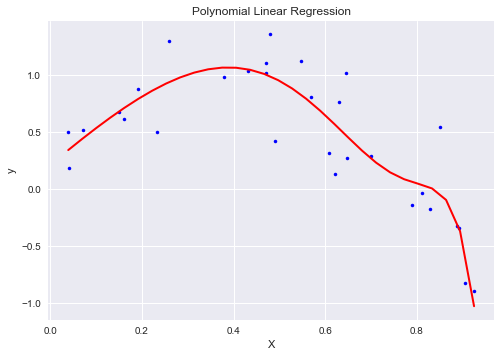

In [303]:
lr_14.plotFinal()

1.5 Fit the data using 16th order polynomial regression model with ridge (L2 penalty) regularization (matrix form,
gradient descent method).


In [3]:
class LR_Poly_Matrix_L2(object):
    def __init__(self, alpha=0.01, n_iter=10, order=1, numda=0, printStep=10, normalize=True):
        self.alpha = alpha
        self.n_iter = n_iter
        self.order = order
        self.numda = numda
        self.printStep = printStep
        self.normalize = normalize
        self.sc_X = StandardScaler()
        self.poly_features = PolynomialFeatures(degree=self.order, include_bias=False)

    def scale(self, X):
        if self.normalize == True:
            X_std = self.sc_X.fit_transform(X)
            X_std1 = np.c_[np.ones((X.shape[0], 1)), X_std]   
        else:
            X_std1 = np.c_[np.ones((X.shape[0], 1)), X]
        return X_std1
    
    # Method 1: Direct Calculate poly features
    def polyX(self, X):  
        X_poly = X
        for i in range(self.order - 1):
            temp = X ** (i+2)
            X_poly = np.concatenate((X_poly, temp), axis=1)
        return X_poly
    
    # Method 2: use sklearn library
    # def polyX(self, X):
    #     X_poly = self.poly_features.fit_transform(X)
    #     return X_poly


    def fit(self, X, y):
        self.X = X
        self.y = y
        if self.order == 1:
            self.X_std1 = self.scale(X)
        else:
            self.X_std1 = self.scale(self.polyX(X))
        self.weights = np.zeros((self.X_std1.shape[1], 1))
        self.cost = []
        self.m = X.shape[0]

        for i in range(self.n_iter):

            # Batch Gradient Descent Using Matrix
            gradients = 2 / self.m * (self.X_std1.T.dot(self.X_std1.dot(self.weights) - self.y) 
                                      + self.numda * self.weights)
            self.weights = self.weights - self.alpha * gradients

            y_predict = self.predict(self.X_std1)
            errors = (y_predict - self.y)
            # RMSE
            cost_ = ((errors ** 2).sum() / self.m) ** 0.5 
            self.cost.append(cost_)
            if (i+1) % self.printStep == 0:
                print('n_iter: %d, RMSE: %f' % (i+1, cost_))
            
        return self

    def predict(self, X):
        predict_std = X.dot(self.weights)
        return predict_std

    def plotFinal(self, xlabel='X', ylabel='y', title='Polynomial Linear Regression'):
        plt.plot(self.X, self.y, "b.")
        if self.order == 1:
            plt.plot(self.X, self.predict(self.X_std1), "g-")
        else:
            X_new = np.linspace(min(self.X), max(self.X), self.m).reshape(-1, 1)
            X_new_poly = self.polyX(X_new)
            X_new_std = self.sc_X.transform(X_new_poly)
            X_final = np.c_[np.ones((X_new.shape[0], 1)), X_new_std]
            y_new = self.predict(X_final)
            plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        # plt.axis([0, max(self.X) + 5, 0, max(self.y) + 1])


Numda 1

In [306]:
lr_15_1 = LR_Poly_Matrix_L2(alpha=0.06, n_iter=5000, order=16, numda=1, printStep=500)
lr_15_1.fit(X, y)

n_iter: 500, RMSE: 0.303192
n_iter: 1000, RMSE: 0.302021
n_iter: 1500, RMSE: 0.301918
n_iter: 2000, RMSE: 0.301909
n_iter: 2500, RMSE: 0.301908
n_iter: 3000, RMSE: 0.301908
n_iter: 3500, RMSE: 0.301908
n_iter: 4000, RMSE: 0.301908
n_iter: 4500, RMSE: 0.301908
n_iter: 5000, RMSE: 0.301908


In [307]:
print('Final RMSE: %f' % lr_15_1.cost[-1])
print('Final Weights:\n', lr_15_1.weights)

Final RMSE: 0.301908
Final Weights:
 [[ 0.43808856]
 [ 0.30532714]
 [-0.11714469]
 [-0.21555533]
 [-0.18959658]
 [-0.12931817]
 [-0.06945018]
 [-0.02187918]
 [ 0.01069068]
 [ 0.02911397]
 [ 0.03545038]
 [ 0.03198174]
 [ 0.02082246]
 [ 0.00379041]
 [-0.01760999]
 [-0.04215991]
 [-0.06888419]]


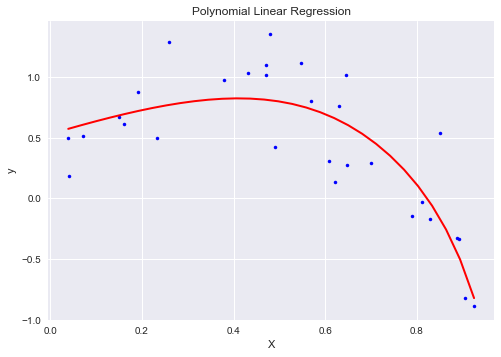

In [308]:
lr_15_1.plotFinal()

Numda 0.01


In [309]:
lr_15_2 = LR_Poly_Matrix_L2(alpha=0.06, n_iter=100000, order=16, numda=0.01, printStep=10000)
lr_15_2.fit(X, y)

n_iter: 10000, RMSE: 0.263146
n_iter: 20000, RMSE: 0.262940
n_iter: 30000, RMSE: 0.262873
n_iter: 40000, RMSE: 0.262849
n_iter: 50000, RMSE: 0.262839
n_iter: 60000, RMSE: 0.262835
n_iter: 70000, RMSE: 0.262834
n_iter: 80000, RMSE: 0.262833
n_iter: 90000, RMSE: 0.262833
n_iter: 100000, RMSE: 0.262832


In [310]:
print('Final RMSE: %f' % lr_15_2.cost[-1])
print('Final Weights:\n', lr_15_2.weights)

Final RMSE: 0.262832
Final Weights:
 [[ 0.45254066]
 [ 0.902857  ]
 [-0.2848238 ]
 [-0.86935974]
 [-0.79763044]
 [-0.44129993]
 [-0.04581015]
 [ 0.27538404]
 [ 0.48215222]
 [ 0.56981511]
 [ 0.54984002]
 [ 0.4404143 ]
 [ 0.26181862]
 [ 0.03413957]
 [-0.2238457 ]
 [-0.49518074]
 [-0.76492331]]


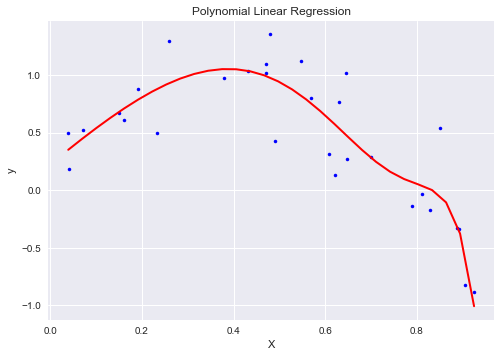

In [311]:
lr_15_2.plotFinal()

Numda 0.0001

In [312]:
lr_15_3 = LR_Poly_Matrix_L2(alpha=0.06, n_iter=100000, order=16, numda=0.0001, printStep=10000)
lr_15_3.fit(X, y)

n_iter: 10000, RMSE: 0.262920
n_iter: 20000, RMSE: 0.262633
n_iter: 30000, RMSE: 0.262535
n_iter: 40000, RMSE: 0.262498
n_iter: 50000, RMSE: 0.262481
n_iter: 60000, RMSE: 0.262471
n_iter: 70000, RMSE: 0.262464
n_iter: 80000, RMSE: 0.262457
n_iter: 90000, RMSE: 0.262452
n_iter: 100000, RMSE: 0.262447


In [313]:
print('Final RMSE: %f' % lr_15_3.cost[-1])
print('Final Weights:\n', lr_15_3.weights)

Final RMSE: 0.262447
Final Weights:
 [[ 0.45269   ]
 [ 0.79766304]
 [ 0.06507666]
 [-0.94545595]
 [-1.04426139]
 [-0.63802441]
 [-0.11440708]
 [ 0.33116388]
 [ 0.62164526]
 [ 0.74035998]
 [ 0.70148235]
 [ 0.53535801]
 [ 0.28051728]
 [-0.02112978]
 [-0.32738012]
 [-0.59777179]
 [-0.79491222]]


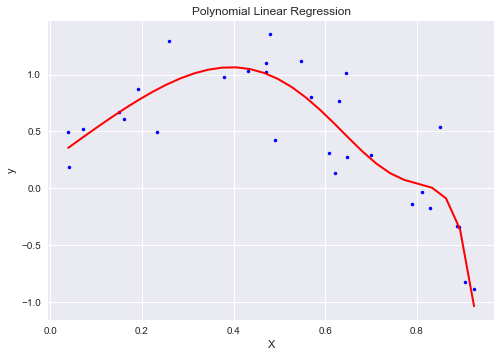

In [314]:
lr_15_3.plotFinal()

Saving figure Poly Regression with L2 Q1.5


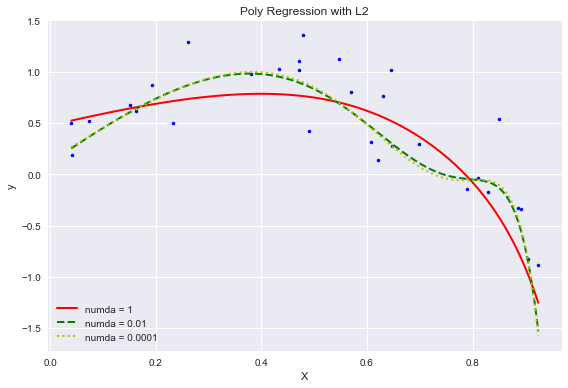

In [315]:
# plot together

plt.plot(X, y, "b.")
X_new=np.linspace(min(X), max(X), 400).reshape(400, 1)
X_new_poly = lr_15_1.scale(lr_15_1.polyX(X_new))
y_new_1 = lr_15_1.predict(X_new_poly)
plt.plot(X_new, y_new_1, "r-", linewidth=2, label='numda = 1')

y_new_2 = lr_15_2.predict(X_new_poly)
plt.plot(X_new, y_new_2, "g--", linewidth=2, label='numda = 0.01')

y_new_3 = lr_15_3.predict(X_new_poly)
plt.plot(X_new, y_new_3, "y:", linewidth=2, label='numda = 0.0001')

plt.xlabel('X')
plt.ylabel('y')
plt.title('Poly Regression with L2')
plt.legend(loc='lower left')
save_fig('Poly Regression with L2 Q1.5')

1.6 Fit the data using 16th order polynomial regression model with scikit-learn Ridge model.


Saving figure Poly Regression with L2 Q1.6


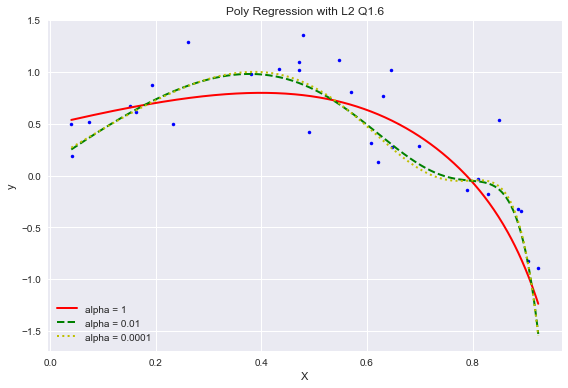

In [316]:
ridge1 = Ridge(alpha=1, fit_intercept=True, normalize=False, random_state=22)
ridge2 = Ridge(alpha=0.01, fit_intercept=True, normalize=False, random_state=22)
ridge3 = Ridge(alpha=0.0001, fit_intercept=True, normalize=False, random_state=22)

plt.plot(X, y, 'b.')

scalar = StandardScaler()
poly_features = PolynomialFeatures(degree=16, include_bias=False)
X_poly = poly_features.fit_transform(X)
X_poly_std = scalar.fit_transform(X_poly)

X_new=np.linspace(min(X), max(X), 400).reshape(400, 1)
X_new_poly = poly_features.transform(X_new)
X_new_std = scalar.fit_transform(X_new_poly)

ridge1.fit(X_poly_std, y)
y_new = ridge1.predict(X_new_std)
plt.plot(X_new, y_new, "r-", linewidth=2, label='alpha = 1')

ridge2.fit(X_poly_std, y)
y_new = ridge2.predict(X_new_std)
plt.plot(X_new, y_new, "g--", linewidth=2, label='alpha = 0.01')

ridge3.fit(X_poly_std, y)
y_new = ridge3.predict(X_new_std)
plt.plot(X_new, y_new, "y:", linewidth=2, label='alpha = 0.0001')

plt.xlabel('X')
plt.ylabel('y')
plt.title('Poly Regression with L2 Q1.6')
plt.legend(loc='lower left')
save_fig('Poly Regression with L2 Q1.6')

In [317]:
RMSE1 = np.sqrt(mean_squared_error(y, ridge1.predict(X_poly_std)))
RMSE2 = np.sqrt(mean_squared_error(y, ridge2.predict(X_poly_std)))
RMSE3 = np.sqrt(mean_squared_error(y, ridge3.predict(X_poly_std)))

print('L2 numda is 1 Final RMSE:', RMSE1)
print('Final Weights:\n', ridge1.coef_.ravel().reshape(-1,1))

print('\nL2 numda is 0.01 Final RMSE:', RMSE2)
print('Final Weights:\n', ridge2.coef_.ravel().reshape(-1,1))

print('\nL2 numda is 0.0001 Final RMSE:', RMSE3)
print('Final Weights:\n', ridge3.coef_.ravel().reshape(-1,1))

L2 numda is 1 Final RMSE: 0.301554692166
Final Weights:
 [[ 0.30532714]
 [-0.11714469]
 [-0.21555533]
 [-0.18959658]
 [-0.12931817]
 [-0.06945018]
 [-0.02187918]
 [ 0.01069068]
 [ 0.02911397]
 [ 0.03545038]
 [ 0.03198174]
 [ 0.02082246]
 [ 0.00379041]
 [-0.01760999]
 [-0.04215991]
 [-0.06888419]]

L2 numda is 0.01 Final RMSE: 0.262832024606
Final Weights:
 [[ 0.9027091 ]
 [-0.28426183]
 [-0.86967025]
 [-0.79808756]
 [-0.44149164]
 [-0.04568321]
 [ 0.27573512]
 [ 0.48257989]
 [ 0.57016159]
 [ 0.54997205]
 [ 0.44025685]
 [ 0.26138411]
 [ 0.03354927]
 [-0.22434919]
 [-0.49522932]
 [-0.76402617]]

L2 numda is 0.0001 Final RMSE: 0.262278013843
Final Weights:
 [[ 0.78742277]
 [-0.01258937]
 [-0.67285702]
 [-0.89205417]
 [-0.95616895]
 [-0.68653987]
 [ 0.00678401]
 [ 0.86836292]
 [ 1.49614163]
 [ 1.5828353 ]
 [ 1.04479622]
 [ 0.04639246]
 [-1.03543339]
 [-1.67044964]
 [-1.23727938]
 [ 0.92164774]]


1.7 Fit the data using 16th order polynomial regression model with scikit-learn Lasso model.


Saving figure Poly Regression with L1 Q1.6


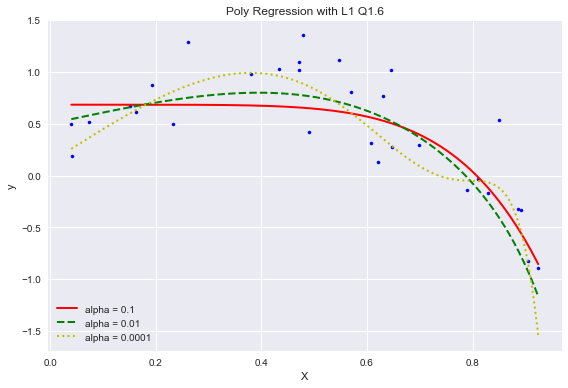

In [318]:
# when numda is 1, it does not converge, so I use 0.1 here
lasso1 = Lasso(alpha=0.1, fit_intercept=True, normalize=False, random_state=22, max_iter=500000)
lasso2 = Lasso(alpha=0.01, fit_intercept=True, normalize=False, random_state=22, max_iter=500000)
lasso3 = Lasso(alpha=0.0001, fit_intercept=True, normalize=False, random_state=22, max_iter=500000)

plt.plot(X, y, 'b.')

scalar = StandardScaler()
poly_features = PolynomialFeatures(degree=16, include_bias=False)
X_poly = poly_features.fit_transform(X)
X_poly_std = scalar.fit_transform(X_poly)

X_new=np.linspace(min(X), max(X), 400).reshape(400, 1)
X_new_poly = poly_features.transform(X_new)
X_new_std = scalar.fit_transform(X_new_poly)

lasso1.fit(X_poly_std, y)
y_new = lasso1.predict(X_new_std)
plt.plot(X_new, y_new, "r-", linewidth=2, label='alpha = 0.1')

lasso2.fit(X_poly_std, y)
y_new = lasso2.predict(X_new_std)
plt.plot(X_new, y_new, "g--", linewidth=2, label='alpha = 0.01')

lasso3.fit(X_poly_std, y)
y_new = lasso3.predict(X_new_std)
plt.plot(X_new, y_new, "y:", linewidth=2, label='alpha = 0.0001')

plt.xlabel('X')
plt.ylabel('y')
plt.title('Poly Regression with L1 Q1.6')
plt.legend(loc='lower left')
save_fig('Poly Regression with L1 Q1.6')

In [319]:
RMSE1 = np.sqrt(mean_squared_error(y, lasso1.predict(X_poly_std)))
RMSE2 = np.sqrt(mean_squared_error(y, lasso2.predict(X_poly_std)))
RMSE3 = np.sqrt(mean_squared_error(y, lasso3.predict(X_poly_std)))

print('L2 numda is 1 Final RMSE:', RMSE1)
print('Final Weights:\n', lasso1.coef_.ravel().reshape(-1,1))

print('\nL2 numda is 0.01 Final RMSE:', RMSE2)
print('Final Weights:\n', lasso2.coef_.ravel().reshape(-1,1))

print('\nL2 numda is 0.0001 Final RMSE:', RMSE3)
print('Final Weights:\n', lasso3.coef_.ravel().reshape(-1,1))

L2 numda is 1 Final RMSE: 0.34466712594
Final Weights:
 [[-0.        ]
 [-0.        ]
 [-0.        ]
 [-0.        ]
 [-0.        ]
 [-0.37373874]
 [-0.        ]
 [-0.        ]
 [-0.        ]
 [-0.        ]
 [-0.        ]
 [-0.        ]
 [-0.        ]
 [-0.        ]
 [-0.        ]
 [-0.        ]]

L2 numda is 0.01 Final RMSE: 0.301820083711
Final Weights:
 [[ 0.27861811]
 [-0.        ]
 [-0.34277251]
 [-0.3061564 ]
 [-0.        ]
 [-0.        ]
 [-0.        ]
 [-0.        ]
 [-0.        ]
 [-0.        ]
 [-0.        ]
 [-0.        ]
 [-0.        ]
 [-0.        ]
 [-0.        ]
 [-0.05833885]]

L2 numda is 0.0001 Final RMSE: 0.262551693069
Final Weights:
 [[ 0.83100475]
 [-0.        ]
 [-0.94464181]
 [-1.37223479]
 [-0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 2.2616591 ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [-0.        ]
 [-0.        ]
 [-1.1833329 ]]


Qustion 2:  Polynomial regression with train/validation/test


In [4]:
df2 = pd.read_csv(DATA_DIR + '/ex2data2.csv')
df2.head()

,sqft_living,price
0,430,80000.0
1,460,247000.0
2,470,192500.0
3,490,150000.0
4,500,125000.0


In [5]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5404 entries, 0 to 5403
Data columns (total 2 columns):
sqft_living    5404 non-null int64
price          5404 non-null float64
dtypes: float64(1), int64(1)
memory usage: 84.5 KB


Saving figure scatter plot Q2


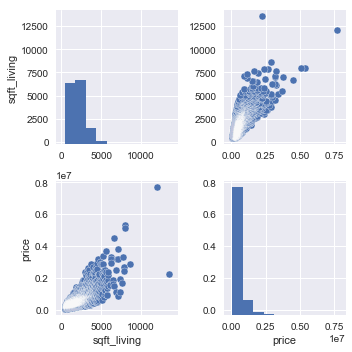

In [6]:
sns.pairplot(df2)
save_fig('scatter plot Q2')

In [7]:
X = df2['sqft_living'].values.reshape(-1, 1).astype('float64')
y = df2['price'].values.reshape(-1, 1).astype('float64')
X.shape, y.shape

((5404, 1), (5404, 1))

Dataset Split

In [8]:
def split_train_val_test(X, y, ratio_train, ratio_val):
    # shuffle the sequence
    np.random.seed(1)
    num = len(y)
    shuffle_index = np.random.permutation(num)
    train_index = shuffle_index[:int(num * ratio_train)]
    val_index = shuffle_index[int(num * ratio_train) : int(num * ratio_train) + int(num * ratio_val)]
    test_index = shuffle_index[int(num * ratio_train) + int(num * ratio_val):]
    X_train, y_train = X[train_index], y[train_index]
    X_val, y_val = X[val_index], y[val_index]
    X_test, y_test = X[test_index], y[test_index]
    return X_train, X_val, X_test, y_train, y_val, y_test


X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(X, y, 0.6, 0.2)

print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_val: ', X_val.shape)
print('y_val: ', y_val.shape)
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)


X_train:  (3242, 1)
y_train:  (3242, 1)
X_val:  (1080, 1)
y_val:  (1080, 1)
X_test:  (1082, 1)
y_test:  (1082, 1)


2.1 Fit the data using linear (1st order) regression model (matrix form, gradient descent method).


In [355]:
lr_21 = LR_Poly_Matrix(alpha=0.1, n_iter=100, order=1, printStep=10, normalize=True)
lr_21.fit(X_train, y_train)

n_iter: 10, RMSE: 276107.918918
n_iter: 20, RMSE: 268116.973352
n_iter: 30, RMSE: 268023.454803
n_iter: 40, RMSE: 268022.376417
n_iter: 50, RMSE: 268022.363985
n_iter: 60, RMSE: 268022.363841
n_iter: 70, RMSE: 268022.363840
n_iter: 80, RMSE: 268022.363839
n_iter: 90, RMSE: 268022.363839
n_iter: 100, RMSE: 268022.363839


In [9]:
def testRMSE(lr, X_test, y_test):
    X_test_poly = lr.polyX(X_test)
    X_test_std = lr.sc_X.transform(X_test_poly)
    X_final = np.c_[np.ones((X_test.shape[0], 1)), X_test_std]    
    y_pred = lr.predict(X_final)
    RMSE = (((y_pred - y_test) ** 2).sum() / lr.m) ** 0.5
    return RMSE

In [357]:
RMSE_test = testRMSE(lr_21, X_test, y_test)


print('Final Training RMSE: %f' % lr_21.cost[-1])
print('Test RMSE: %f' % RMSE_test)
print('Final Weights:\n', lr_21.weights)

Final Training RMSE: 268022.363839
Test RMSE: 151068.883547
Final Weights:
 [[ 543475.44344265]
 [ 293663.94223358]]


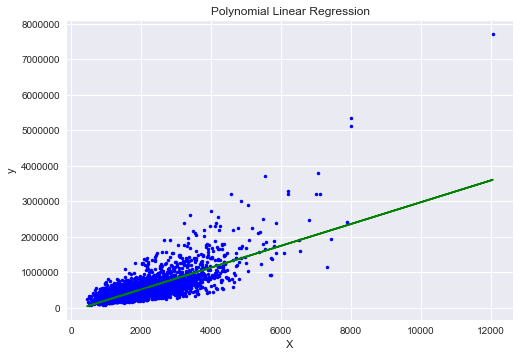

In [358]:
lr_21.plotFinal()

Test with normal equation

In [329]:
class NormalEquation(object):

    def __init__(self):
        pass

    def fit(self, X, y):
        self.X = X
        self.y = y
        # it's ok if not normalizing the data when using Normal Equation
        self.sc_X = StandardScaler()
        self.X_std = self.sc_X.fit_transform(X)
        self.X_new = np.c_[np.ones(shape=(len(y), 1)), self.X_std]
        self.weights = np.linalg.inv(self.X_new.T.dot(self.X_new)).dot(self.X_new.T).dot(y)
        self.cost = (((self.predict() - y) ** 2).sum() / len(y)) ** 0.5
        return self

    def predict(self):
        predict = self.X_new.dot(self.weights)
        return predict


In [330]:
ne_21 = NormalEquation()
ne_21.fit(X_train, y_train)

In [331]:
print('RMSE: %f' % ne_21.cost)
print('Weights: ', ne_21.weights)

RMSE: 268022.363839
Weights:  [[ 543475.44355336]
 [ 293663.9422934 ]]


The Results of Normal Equation and Gradient Descent are the same

2.2 Fit the data using 2nd order polynomial regression model (matrix form, gradient descent method).


In [362]:
lr_22 = LR_Poly_Matrix(alpha=0.1, n_iter=1000, order=2, printStep=100, normalize=True)
lr_22.fit(X_train, y_train)

n_iter: 100, RMSE: 241602.917684
n_iter: 200, RMSE: 241237.999936
n_iter: 300, RMSE: 241218.320590
n_iter: 400, RMSE: 241217.260119
n_iter: 500, RMSE: 241217.202975
n_iter: 600, RMSE: 241217.199896
n_iter: 700, RMSE: 241217.199730
n_iter: 800, RMSE: 241217.199721
n_iter: 900, RMSE: 241217.199721
n_iter: 1000, RMSE: 241217.199721


In [363]:
RMSE_test = testRMSE(lr_22, X_test, y_test)

print('Final Training RMSE: %f' % lr_22.cost[-1])
print('Test RMSE: %f' % RMSE_test)
print('Final Weights:\n', lr_22.weights)

Final Training RMSE: 241217.199721
Test RMSE: 198266.546407
Final Weights:
 [[ 543475.44355336]
 [   3765.90683441]
 [ 312555.78359956]]


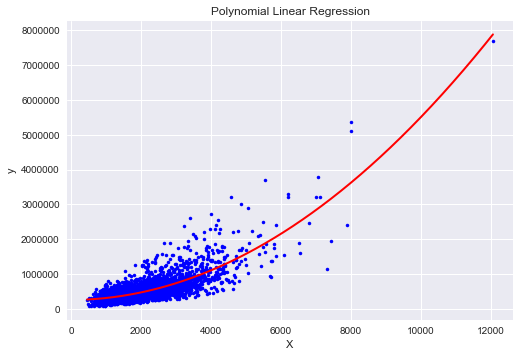

In [364]:
lr_22.plotFinal()

2.3 Fit the data using 4th order polynomial regression model (matrix form, gradient descent method).


In [365]:
lr_23 = LR_Poly_Matrix(alpha=0.1, n_iter=50000, order=4, printStep=5000, normalize=True)
lr_23.fit(X_train, y_train)

n_iter: 5000, RMSE: 241218.587859
n_iter: 10000, RMSE: 241203.698874
n_iter: 15000, RMSE: 241195.807822
n_iter: 20000, RMSE: 241191.625714
n_iter: 25000, RMSE: 241189.409303
n_iter: 30000, RMSE: 241188.234669
n_iter: 35000, RMSE: 241187.612149
n_iter: 40000, RMSE: 241187.282232
n_iter: 45000, RMSE: 241187.107387
n_iter: 50000, RMSE: 241187.014725


In [366]:
RMSE_test = testRMSE(lr_23, X_test, y_test)

print('Final Training RMSE: %f' % lr_23.cost[-1])
print('Test RMSE: %f' % RMSE_test)
print('Final Weights:\n', lr_23.weights)

Final Training RMSE: 241187.014725
Test RMSE: 196525.997063
Final Weights:
 [[ 543475.44355336]
 [ -27607.82489259]
 [ 383422.67794064]
 [ -62284.31926824]
 [  20403.59542575]]


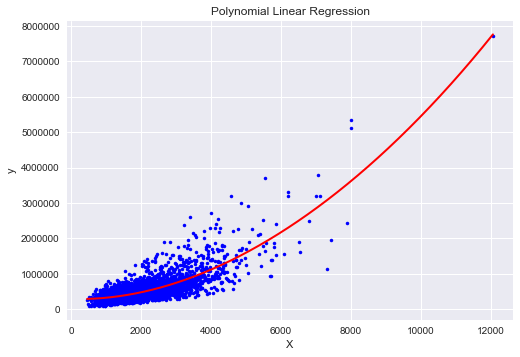

In [367]:
lr_23.plotFinal()

2.4 Fit the data using 16th order polynomial regression model (matrix form, gradient descent method).


In [ ]:
lr_24 = LR_Poly_Matrix(alpha=0.06, n_iter=500000, order=16, printStep=50000, normalize=True)
lr_24.fit(X_train, y_train)

In [385]:
RMSE_test = testRMSE(lr_24, X_test, y_test)

print('Final Training RMSE: %f' % lr_24.cost[-1])
print('Test RMSE: %f' % RMSE_test)
print('Final Weights:\n', lr_24.weights)

Final Training RMSE: 239469.056575
Test RMSE: 8814182.029756
Final Weights:
 [[  543475.44355337]
 [  147478.43521643]
 [ -400800.52871582]
 [ 1386368.01820877]
 [ -568979.01581816]
 [-1308197.35737969]
 [ -443480.15368021]
 [  643657.7147478 ]
 [ 1265639.653029  ]
 [ 1358316.88466873]
 [ 1085891.1972913 ]
 [  630454.780285  ]
 [  124385.8128592 ]
 [ -354709.95523705]
 [ -770163.97734413]
 [-1110930.48715082]
 [-1379912.54542548]]


The Test Cost is huge. This model overfitted

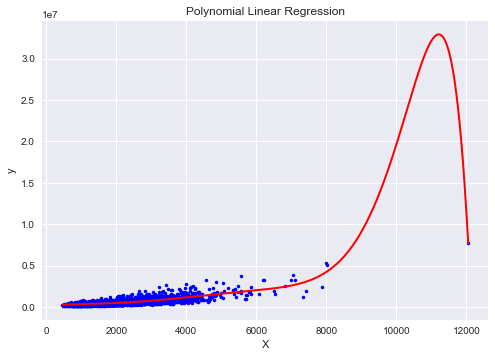

In [386]:
lr_24.plotFinal()

2.5 Fit the data using 16th order polynomial regression model with ridge (L2 penalty) regularization.


In [10]:
def ValRMSE(lr, X_val, y_val):
    X_val_poly = lr.polyX(X_val)
    X_val_std = lr.sc_X.transform(X_val_poly)
    X_final = np.c_[np.ones((X_val.shape[0], 1)), X_val_std]    
    y_pred = lr.predict(X_final)
    RMSE = (((y_pred - y_val) ** 2).sum() / lr.m) ** 0.5
    return RMSE

Try 10 numda values from 1e-5 to 1e5

In [403]:
lamda = np.logspace(-5, 5, num=20)
weights = []

for i in range(len(lamda)):
    lr_25 = LR_Poly_Matrix_L2(alpha=0.01, numda=lamda[i], n_iter=10000, order=16, 
                              printStep=10001, normalize=True)
    lr_25.fit(X_train, y_train)
    
    Val_RMSE = ValRMSE(lr_25, X_val, y_val)
    weights.append(lr_25.weights.ravel())
    print('lamda: ', lamda[i], ' Val_RMSE: ', Val_RMSE)

lamda:  1e-05  Val_RMSE:  157927.6228
lamda:  3.35981828628e-05  Val_RMSE:  157927.623202
lamda:  0.000112883789168  Val_RMSE:  157927.624553
lamda:  0.000379269019073  Val_RMSE:  157927.629091
lamda:  0.0012742749857  Val_RMSE:  157927.644338
lamda:  0.00428133239872  Val_RMSE:  157927.695564
lamda:  0.0143844988829  Val_RMSE:  157927.867645
lamda:  0.0483293023857  Val_RMSE:  157928.445488
lamda:  0.162377673919  Val_RMSE:  157930.383342
lamda:  0.545559478117  Val_RMSE:  157936.853805
lamda:  1.83298071083  Val_RMSE:  157958.144384
lamda:  6.15848211066  Val_RMSE:  158024.866384
lamda:  20.6913808111  Val_RMSE:  158204.148269
lamda:  69.5192796178  Val_RMSE:  158553.02047
lamda:  233.572146909  Val_RMSE:  159702.15746
lamda:  784.759970351  Val_RMSE:  169248.796686
lamda:  2636.65089873  Val_RMSE:  213170.893238
lamda:  8858.6679041  Val_RMSE:  288372.898425
lamda:  29763.5144163  Val_RMSE:  344483.451952
lamda:  100000.0  Val_RMSE:  370411.783523


Saving figure Ridge coefficients as a function of the regularization


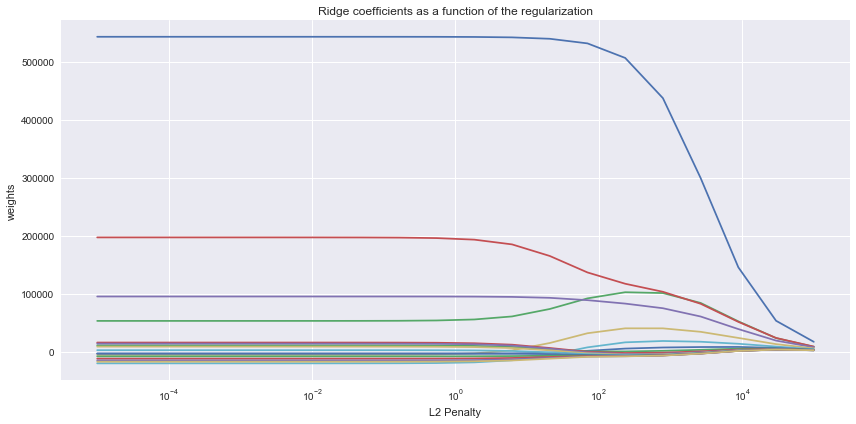

In [410]:
plt.figure(figsize=(12, 6))
ax = plt.gca()
ax.plot(lamda, weights)
ax.set_xscale('log')
plt.xlabel('L2 Penalty')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')

save_fig('Ridge coefficients as a function of the regularization')

1. The Result shows that for this model, Lamda is better to be in range 1e1 to 1e-5.
2. I will choose 1e-5 based on the Validation RMSE

In [413]:
lr_25 = LR_Poly_Matrix_L2(alpha=0.01, numda=1e-5, n_iter=10000, order=16, 
                              printStep=1000, normalize=True)
lr_25.fit(X_train, y_train)

n_iter: 1000, RMSE: 241546.629243
n_iter: 2000, RMSE: 241471.723593
n_iter: 3000, RMSE: 241416.222055
n_iter: 4000, RMSE: 241373.804600
n_iter: 5000, RMSE: 241340.241890
n_iter: 6000, RMSE: 241312.696611
n_iter: 7000, RMSE: 241289.265122
n_iter: 8000, RMSE: 241268.669896
n_iter: 9000, RMSE: 241250.053230
n_iter: 10000, RMSE: 241232.838898


In [414]:
RMSE_test = testRMSE(lr_25, X_test, y_test)
RMSE_val = ValRMSE(lr_25, X_val, y_val)

print('Final Training RMSE: %f' % lr_25.cost[-1])
print('Validation RMSE: %f' % RMSE_val)
print('Test RMSE: %f' % RMSE_test)
print('Final Weights:\n', lr_25.weights)

Final Training RMSE: 241232.838898
Validation RMSE: 157927.622800
Test RMSE: 152238.302052
Final Weights:
 [[ 543475.441877  ]
 [  53144.12188637]
 [ 197240.0551423 ]
 [  95288.25174458]
 [  -5490.55305445]
 [ -20116.20228763]
 [  -3300.21719132]
 [  10888.88434318]
 [  15808.55514577]
 [  13946.03357631]
 [   8760.27446076]
 [   2637.40763038]
 [  -3149.72671158]
 [  -8070.3649862 ]
 [ -12004.55312823]
 [ -15027.29984872]
 [ -17286.64358336]]


Saving figure L2 = 1e-5


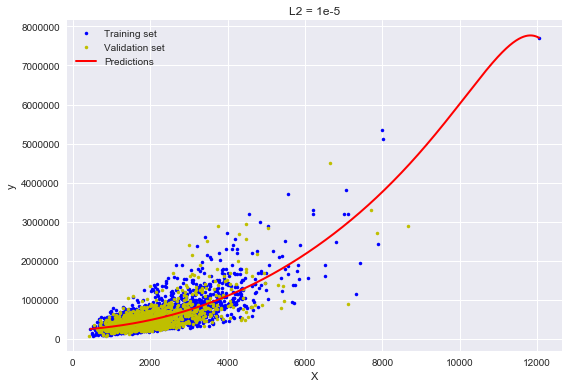

In [418]:
plt.plot(X_train, y_train, "b.", label="Training set")
plt.plot(X_val, y_val, "y.", label="Validation set")

X_new = np.linspace(min(X_train), max(X_train), X_train.shape[0]).reshape(-1, 1)
X_new_poly = lr_25.polyX(X_new)
X_new_std = lr_25.sc_X.transform(X_new_poly)
X_final = np.c_[np.ones((X_new.shape[0], 1)), X_new_std]
y_new = lr_25.predict(X_final)
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")

plt.legend(loc='upper left')
plt.xlabel('X')
plt.ylabel('y')
plt.title('L2 = 1e-5')
save_fig('L2 = 1e-5')

2.6 Fit the data using 16th order polynomial regression model with scikit-learn Ridge model.


In [430]:
ridge = Ridge(alpha=1, fit_intercept=True, normalize=False, random_state=22)

scalar = StandardScaler()
poly_features = PolynomialFeatures(degree=16, include_bias=False)
X_poly = poly_features.fit_transform(X_train)
X_poly_std = scalar.fit_transform(X_poly)

lamda = np.logspace(-5, 5, num=20)
coefs = []

for i in range(len(lamda)):
    ridge.set_params(alpha=lamda[i])
    ridge.fit(X_poly_std, y_train)
    RMSE = np.sqrt(mean_squared_error(y_train, ridge.predict(X_poly_std)))
    coefs.append(ridge.coef_.ravel())
    print('lamda: ', lamda[i], ' RMSE: ', RMSE)

lamda:  1e-05  RMSE:  238233.552089
lamda:  3.35981828628e-05  RMSE:  238445.732062
lamda:  0.000112883789168  RMSE:  238718.041597
lamda:  0.000379269019073  RMSE:  238912.829945
lamda:  0.0012742749857  RMSE:  239040.955699
lamda:  0.00428133239872  RMSE:  239173.130093
lamda:  0.0143844988829  RMSE:  239309.589679
lamda:  0.0483293023857  RMSE:  239559.19893
lamda:  0.162377673919  RMSE:  239953.879146
lamda:  0.545559478117  RMSE:  240301.201659
lamda:  1.83298071083  RMSE:  240665.929763
lamda:  6.15848211066  RMSE:  241050.877778
lamda:  20.6913808111  RMSE:  241305.345877
lamda:  69.5192796178  RMSE:  241485.93755
lamda:  233.572146909  RMSE:  241741.079739
lamda:  784.759970351  RMSE:  243188.311246
lamda:  2636.65089873  RMSE:  252823.484107
lamda:  8858.6679041  RMSE:  285528.556257
lamda:  29763.5144163  RMSE:  330863.447249
lamda:  100000.0  RMSE:  366003.399857


Saving figure Ridge coefficients as a function of the regularization


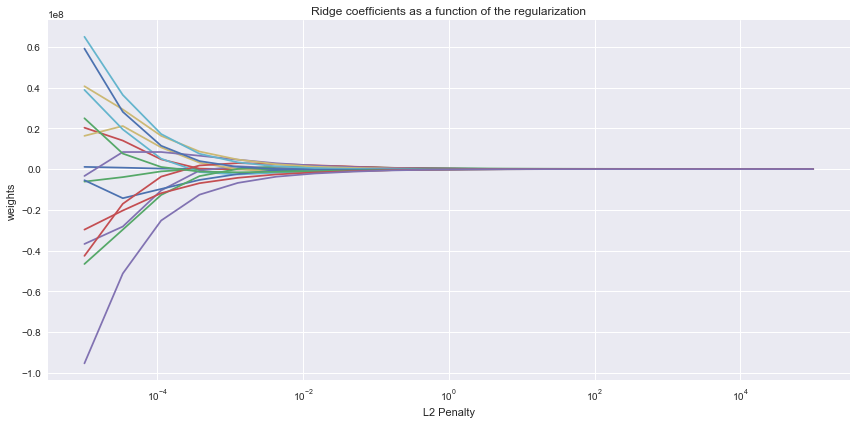

In [431]:
plt.figure(figsize=(12, 6))
ax = plt.gca()
ax.plot(lamda, coefs)
ax.set_xscale('log')
plt.xlabel('L2 Penalty')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')

save_fig('Ridge coefficients as a function of the regularization')

Lamda is better in range 1e0 to 1e5

Saving figure Poly Regression with L2 Q1.6


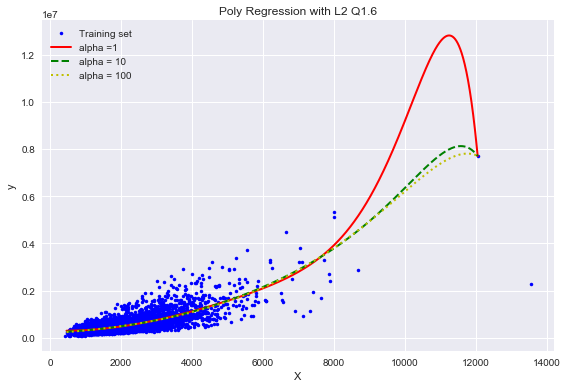

In [442]:
ridge1 = Ridge(alpha=1e0, fit_intercept=True, normalize=False, random_state=22)
ridge2 = Ridge(alpha=1e1, fit_intercept=True, normalize=False, random_state=22)
ridge3 = Ridge(alpha=1e2, fit_intercept=True, normalize=False, random_state=22)

plt.plot(X, y, 'b.', label="Training set")

scalar = StandardScaler()
poly_features = PolynomialFeatures(degree=16, include_bias=False)
X_poly = poly_features.fit_transform(X_train)
X_poly_std = scalar.fit_transform(X_poly)

X_new=np.linspace(min(X_train), max(X_train), X_train.shape[0]).reshape(-1, 1)
X_new_poly = poly_features.transform(X_new)
X_new_std = scalar.transform(X_new_poly)

ridge1.fit(X_poly_std, y_train)
y_new = ridge1.predict(X_new_std)
plt.plot(X_new, y_new, "r-", linewidth=2, label='alpha =1')
ridge2.fit(X_poly_std, y_train)
y_new = ridge2.predict(X_new_std)
plt.plot(X_new, y_new, "g--", linewidth=2, label='alpha = 10')

ridge3.fit(X_poly_std, y_train)
y_new = ridge3.predict(X_new_std)
plt.plot(X_new, y_new, "y:", linewidth=2, label='alpha = 100')

plt.xlabel('X')
plt.ylabel('y')
plt.title('Poly Regression with L2 Q1.6')
plt.legend(loc='upper left')
save_fig('Poly Regression with L2 Q1.6')

I will choose lamda to be 10

In [444]:
RMSE = np.sqrt(mean_squared_error(y_train, ridge2.predict(X_poly_std)))
print('training RMSE is: ', RMSE, '\nWeight is: ', ridge2.coef_.ravel())

training RMSE is:  241168.796966 
Weight is:  [  49761.30424456  209555.54882115   85289.08804778  -19568.42517058
  -19408.69980174   10236.65243588   29046.02902056   32272.22646013
   25541.37575703   14564.84684285    2951.11685909   -7511.37690637
  -16172.0369229   -22979.94410325  -28150.26394477  -31982.56635586]


2.7 Fit the data using 16th order polynomial regression model with scikit-learn Lasso model.


In [16]:
lasso = Lasso(alpha=1, fit_intercept=True, normalize=False, random_state=22, tol=1e0, max_iter=1e5)

scalar = StandardScaler()
poly_features = PolynomialFeatures(degree=16, include_bias=False)
X_poly = poly_features.fit_transform(X_train)
X_poly_std = scalar.fit_transform(X_poly)

lamda = np.logspace(-2, 6, num=10)
coefs = []

for i in range(len(lamda)):
    lasso.set_params(alpha=lamda[i])
    lasso.fit(X_poly_std, y_train)
    RMSE = np.sqrt(mean_squared_error(y_train, lasso.predict(X_poly_std)))
    coefs.append(lasso.coef_.ravel())
    print('lamda: ', lamda[i], ' RMSE: ', RMSE)

lamda:  0.01  RMSE:  246646.526364
lamda:  0.0774263682681  RMSE:  246646.518213
lamda:  0.599484250319  RMSE:  246646.455109
lamda:  4.64158883361  RMSE:  246645.975822
lamda:  35.938136638  RMSE:  246642.4306
lamda:  278.255940221  RMSE:  246617.18718
lamda:  2154.43469003  RMSE:  246532.88511
lamda:  16681.005372  RMSE:  246419.833209
lamda:  129154.966501  RMSE:  275503.978385
lamda:  1000000.0  RMSE:  397585.837929


Saving figure Ridge coefficients as a function of the regularization


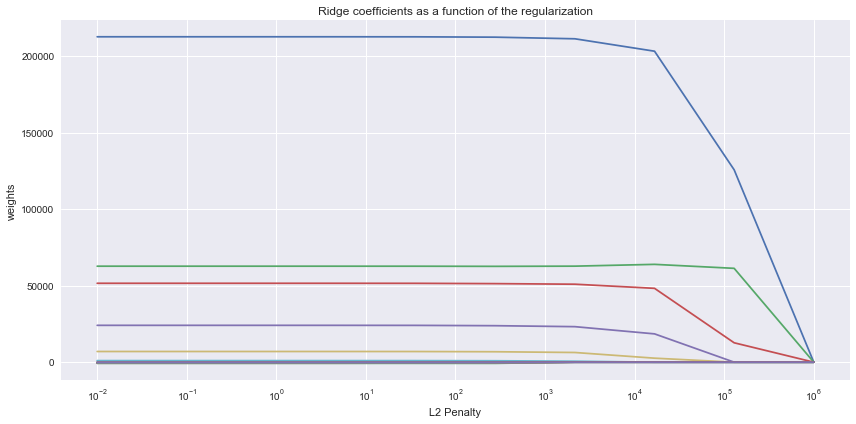

In [17]:
plt.figure(figsize=(12, 6))
ax = plt.gca()
ax.plot(lamda, coefs)
ax.set_xscale('log')
plt.xlabel('L2 Penalty')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization')
plt.axis('tight')

save_fig('Lasso coefficients as a function of the regularization')

Saving figure Poly Regression with L2 Q1.6


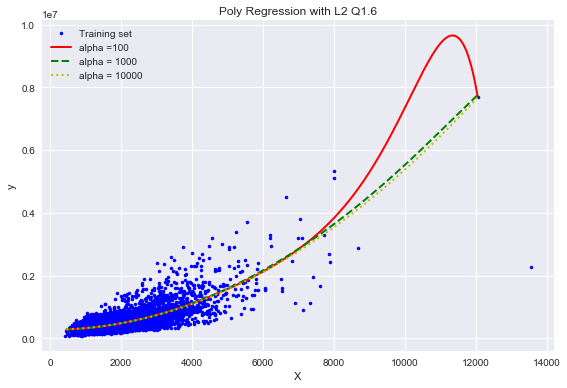

In [26]:
lasso1 = Lasso(alpha=1e2, fit_intercept=True, normalize=False, random_state=22, max_iter=1e5)
lasso2 = Lasso(alpha=1e3, fit_intercept=True, normalize=False, random_state=22, max_iter=1e5)
lasso3 = Lasso(alpha=1e4, fit_intercept=True, normalize=False, random_state=22, max_iter=1e5)

plt.plot(X, y, 'b.', label="Training set")

scalar = StandardScaler()
poly_features = PolynomialFeatures(degree=16, include_bias=False)
X_poly = poly_features.fit_transform(X_train)
X_poly_std = scalar.fit_transform(X_poly)

X_new=np.linspace(min(X_train), max(X_train), X_train.shape[0]).reshape(-1, 1)
X_new_poly = poly_features.transform(X_new)
X_new_std = scalar.transform(X_new_poly)

lasso1.fit(X_poly_std, y_train)
y_new = lasso1.predict(X_new_std)
plt.plot(X_new, y_new, "r-", linewidth=2, label='alpha =100')
lasso2.fit(X_poly_std, y_train)
y_new = lasso2.predict(X_new_std)
plt.plot(X_new, y_new, "g--", linewidth=2, label='alpha = 1000')

lasso3.fit(X_poly_std, y_train)
y_new = lasso3.predict(X_new_std)
plt.plot(X_new, y_new, "y:", linewidth=2, label='alpha = 10000')

plt.xlabel('X')
plt.ylabel('y')
plt.title('Poly Regression with L2 Q1.6')
plt.legend(loc='upper left')
save_fig('Poly Regression with L2 Q1.6')

I will choose lamda 1e3

In [27]:
RMSE = np.sqrt(mean_squared_error(y_train, lasso2.predict(X_poly_std)))
print('training RMSE is: ', RMSE, '\nWeight is: ', lasso2.coef_.ravel())

training RMSE is:  241192.74718 
Weight is:  [      0.          316219.54754349       0.               0.              -0.
      -0.              -0.              -0.              -0.              -0.
      -0.              -0.              -0.              -0.
    -442.78530724   -2407.23582254]


Qestion 3. Regularization with Tensorflow


In [2]:
df3 = pd.read_csv(DATA_DIR + '/ex2data3.csv')
df3.head()

,Unnamed: 0,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,price
0,0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


Eliminate the first column

In [3]:
df3 = df3.iloc[:, 1:]
df3.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,price
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [4]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
MedInc        20640 non-null float64
HouseAge      20640 non-null float64
AveRooms      20640 non-null float64
AveBedrms     20640 non-null float64
Population    20640 non-null float64
AveOccup      20640 non-null float64
Latitude      20640 non-null float64
Longitude     20640 non-null float64
price         20640 non-null float64
dtypes: float64(9)
memory usage: 1.4 MB


In [5]:
X = df3.iloc[:, :-1].values.astype('float64')
y = df3['price'].values.reshape(-1, 1).astype('float64')
X.shape, y.shape

((20640, 8), (20640, 1))

In [6]:
def split_train_val_test(X, y, ratio_train, ratio_val):
    # shuffle the sequence
    np.random.seed(1)
    num = len(y)
    shuffle_index = np.random.permutation(num)
    train_index = shuffle_index[:int(num * ratio_train)]
    val_index = shuffle_index[int(num * ratio_train) : int(num * ratio_train) + int(num * ratio_val)]
    test_index = shuffle_index[int(num * ratio_train) + int(num * ratio_val):]
    X_train, y_train = X[train_index], y[train_index]
    X_val, y_val = X[val_index], y[val_index]
    X_test, y_test = X[test_index], y[test_index]
    return X_train, X_val, X_test, y_train, y_val, y_test


X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(X, y, 0.6, 0.2)

print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_val: ', X_val.shape)
print('y_val: ', y_val.shape)
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)

X_train:  (12384, 8)
y_train:  (12384, 1)
X_val:  (4128, 8)
y_val:  (4128, 1)
X_test:  (4128, 8)
y_test:  (4128, 1)


3.1 Fit the training data using regression model with ridge (L2 penalty) regularization with scikit-learn Ridge model.


In [64]:
ridge = Ridge(alpha=1, fit_intercept=True, normalize=False, random_state=22)

scalar = StandardScaler()
X_train_std = scalar.fit_transform(X_train)
X_val_std = scalar.fit_transform(X_val)
X_test_std = scalar.fit_transform(X_test)

lamda = np.logspace(-5, 5, num=20)
coefs = []

for i in range(len(lamda)):
    ridge.set_params(alpha=lamda[i])
    ridge.fit(X_train_std, y_train)
    RMSE_val = np.sqrt(mean_squared_error(y_val, ridge.predict(X_val_std)))
    coefs.append(ridge.coef_.ravel())
    print('lamda: ', lamda[i], ' RMSE_val: ', RMSE_val)

lamda:  1e-05  RMSE_val:  0.71264937963
lamda:  3.35981828628e-05  RMSE_val:  0.712649379499
lamda:  0.000112883789168  RMSE_val:  0.712649379061
lamda:  0.000379269019073  RMSE_val:  0.712649377589
lamda:  0.0012742749857  RMSE_val:  0.712649372645
lamda:  0.00428133239872  RMSE_val:  0.712649356033
lamda:  0.0143844988829  RMSE_val:  0.712649300236
lamda:  0.0483293023857  RMSE_val:  0.712649112954
lamda:  0.162377673919  RMSE_val:  0.712648485805
lamda:  0.545559478117  RMSE_val:  0.7126464022
lamda:  1.83298071083  RMSE_val:  0.712639665974
lamda:  6.15848211066  RMSE_val:  0.712619980393
lamda:  20.6913808111  RMSE_val:  0.712585761996
lamda:  69.5192796178  RMSE_val:  0.712785699834
lamda:  233.572146909  RMSE_val:  0.715791827967
lamda:  784.759970351  RMSE_val:  0.733359703371
lamda:  2636.65089873  RMSE_val:  0.780223333147
lamda:  8858.6679041  RMSE_val:  0.864936777962
lamda:  29763.5144163  RMSE_val:  0.990743870573
lamda:  100000.0  RMSE_val:  1.0895211094


(3.1622776601683792e-06,
 316227.76601683791,
 -0.98070213109860316,
 0.9467361811175784)

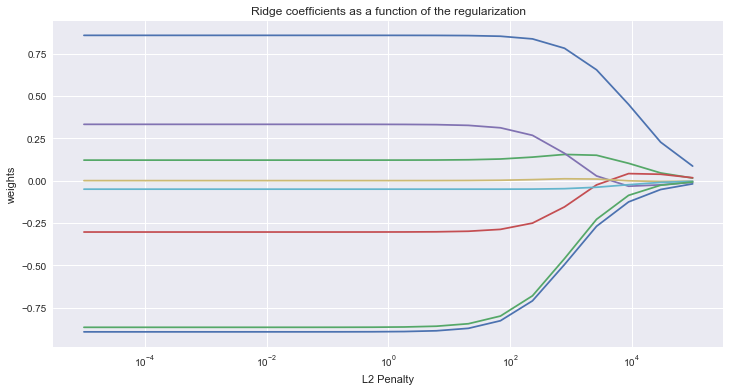

In [65]:
plt.figure(figsize=(12, 6))
ax = plt.gca()
ax.plot(lamda, coefs)
ax.set_xscale('log')
plt.xlabel('L2 Penalty')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')

better in range 1e-5 to 1e0, I choose 1e-4

In [66]:
ridge = Ridge(alpha=1e-4, fit_intercept=True, normalize=False, random_state=22)
ridge.fit(X_train_std, y_train)

RMSE_train = np.sqrt(mean_squared_error(y_train, ridge.predict(X_train_std)))
RMSE_val = np.sqrt(mean_squared_error(y_val, ridge.predict(X_val_std)))
RMSE_test = np.sqrt(mean_squared_error(y_test, ridge.predict(X_test_std)))

print('RMSE_train:%f\nRMSE_val:%f\nRMSE_test:%f' % (RMSE_train, RMSE_val, RMSE_test))
print('Final Weights:\n', ridge.coef_)

RMSE_train:0.723845
RMSE_val:0.712649
RMSE_test:0.722806
Final Weights:
 [[  8.59125343e-01   1.21753718e-01  -3.03150625e-01   3.33296163e-01
    6.30946466e-04  -4.98669153e-02  -8.93091206e-01  -8.66177167e-01]]


3.2 Fit the training data using regression model with lasso (L1 penalty) regularization with scikit-learn Lasso model.
 (for example, λ = 0.1, 1, 10). 

In [67]:
lasso = Lasso(alpha=1, fit_intercept=True, normalize=False, random_state=22)

scalar = StandardScaler()
X_train_std = scalar.fit_transform(X_train)
X_val_std = scalar.fit_transform(X_val)
X_test_std = scalar.fit_transform(X_test)

lamda = np.logspace(-7, 3, num=20)
coefs = []

for i in range(len(lamda)):
    lasso.set_params(alpha=lamda[i])
    lasso.fit(X_train_std, y_train)
    RMSE_val = np.sqrt(mean_squared_error(y_val, lasso.predict(X_val_std)))
    coefs.append\
        (lasso.coef_.ravel())
    print('lamda: ', lamda[i], ' RMSE_val: ', RMSE_val)

lamda:  1e-07  RMSE_val:  0.712649345079
lamda:  3.35981828628e-07  RMSE_val:  0.71264926337
lamda:  1.12883789168e-06  RMSE_val:  0.712648989042
lamda:  3.79269019073e-06  RMSE_val:  0.712648068063
lamda:  1.2742749857e-05  RMSE_val:  0.712644976443
lamda:  4.28133239872e-05  RMSE_val:  0.712634651064
lamda:  0.000143844988829  RMSE_val:  0.7126005644
lamda:  0.000483293023857  RMSE_val:  0.712493103811
lamda:  0.00162377673919  RMSE_val:  0.712209009017
lamda:  0.00545559478117  RMSE_val:  0.712144872454
lamda:  0.0183298071083  RMSE_val:  0.721962061467
lamda:  0.0615848211066  RMSE_val:  0.795099769148
lamda:  0.206913808111  RMSE_val:  0.858619336993
lamda:  0.695192796178  RMSE_val:  1.09150372835
lamda:  2.33572146909  RMSE_val:  1.15605039885
lamda:  7.84759970351  RMSE_val:  1.15605039885
lamda:  26.3665089873  RMSE_val:  1.15605039885
lamda:  88.586679041  RMSE_val:  1.15605039885
lamda:  297.635144163  RMSE_val:  1.15605039885
lamda:  1000.0  RMSE_val:  1.15605039885


(3.1622776601683792e-08,
 3162.2776601683763,
 -0.98070098096862524,
 0.94673559473515245)

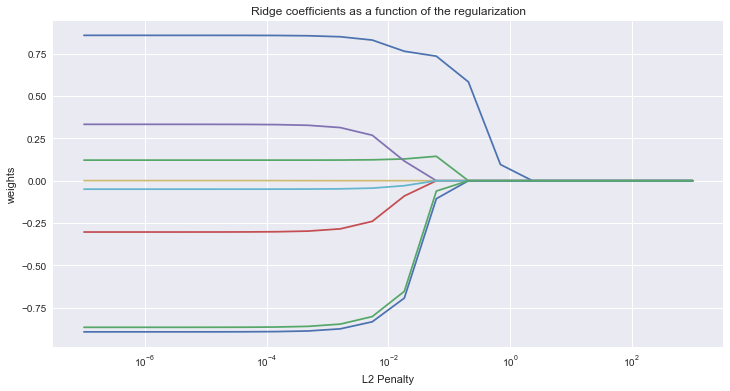

In [58]:
plt.figure(figsize=(12, 6))
ax = plt.gca()
ax.plot(lamda, coefs)
ax.set_xscale('log')
plt.xlabel('L2 Penalty')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')

Lamda better to be in range 1e-7 to 1e-3, I choose 1e-5 here

In [68]:
lasso = Lasso(alpha=1e-5, fit_intercept=True, normalize=False, random_state=22)
lasso.fit(X_train_std, y_train)

RMSE_train = np.sqrt(mean_squared_error(y_train, lasso.predict(X_train_std)))
RMSE_val = np.sqrt(mean_squared_error(y_val, lasso.predict(X_val_std)))
RMSE_test = np.sqrt(mean_squared_error(y_test, lasso.predict(X_test_std)))

print('RMSE_train:%f\nRMSE_val:%f\nRMSE_test:%f' % (RMSE_train, RMSE_val, RMSE_test))
print('Final Weights:\n', lasso.coef_)

RMSE_train:0.723845
RMSE_val:0.712646
RMSE_test:0.722803
Final Weights:
 [  8.59074557e-01   1.21754314e-01  -3.03036641e-01   3.33178549e-01
   6.20704728e-04  -4.98550211e-02  -8.92983113e-01  -8.66061407e-01]


3.3 Fit the training data using regression model with ridge (L2 penalty) regularization using TensorFlow.


In [51]:
import tensorflow as tf

class LR_L2_TF(object): 
    
    def __init__(self, alpha=0.01, n_iter=10, lamda=0, printStep=10):
        self.alpha = alpha
        self.n_iter = n_iter
        self.lamda = lamda
        self.printStep = printStep
        self.scalar = StandardScaler()
           
    def fit(self, X, y):
        
        m, n = X.shape
        X_std = self.scalar.fit_transform(X) 
        X_scaled_bias = np.c_[np.ones((m, 1)), X_std]
          
        X = tf.constant(X_scaled_bias, dtype=tf.float64, name="X")
        y = tf.constant(y, dtype=tf.float64, name="y")
        self.weights = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=1, dtype=tf.float64), 
                                   name="weights")
        
        y_pred = tf.matmul(X, self.weights, name="predictions")
        error = y_pred - y
        RMSE = tf.sqrt(tf.reduce_mean(tf.square(error), name="mse"))
        gradients = 2/m * (tf.matmul(tf.transpose(X), error) + self.lamda * self.weights)
        training_op = tf.assign(self.weights, self.weights - self.alpha * gradients)
        
        init = tf.global_variables_initializer()
        
        with tf.Session() as sess:
            sess.run(init)
        
            for epoch in range(self.n_iter):
                if (epoch+1) % self.printStep == 0:
                    print("Epoch", epoch + 1, "RMSE =", RMSE.eval())
                sess.run(training_op)
            self.getweights = self.weights.eval()
            self.myRMSE = RMSE.eval()
        sess.close() 
        
        return self
    
    def getRMSE(self, X, y):     
        X_std = self.scalar.transform(X) 
        X_std1 = np.c_[np.ones((X.shape[0], 1)), X_std]  
        
        X = tf.constant(X_std1, dtype=tf.float64, name="X")
        y = tf.constant(y, dtype=tf.float64, name="y")
        
        y_pred = tf.matmul(X, self.getweights)
        error = y_pred - y 
        RMSE = tf.sqrt(tf.reduce_mean(tf.square(error)))
        
        with tf.Session() as sess:
            haha = RMSE.eval()
        sess.close() 
        
        return haha
        

In [58]:
lamda = np.logspace(-5, 5, num=20)
coefs = []
RMSE_val_set = []
for i in range(len(lamda)):
    lr_33 = LR_L2_TF(alpha=0.1, n_iter=2000, lamda=lamda[i], printStep=5000)
    lr_33.fit(X_train, y_train)
    coefs.append(lr_33.getweights.reshape(-1))
    RMSE_val = lr_33.getRMSE(X_val, y_val)
    RMSE_val_set.append(RMSE_val)
    print('lamda: ', lamda[i], ' RMSE_val: ', RMSE_val)

lamda:  1e-05  RMSE_val:  0.711583611307
lamda:  3.35981828628e-05  RMSE_val:  0.711583611236
lamda:  0.000112883789168  RMSE_val:  0.711583610996
lamda:  0.000379269019073  RMSE_val:  0.711583610191
lamda:  0.0012742749857  RMSE_val:  0.711583607486
lamda:  0.00428133239872  RMSE_val:  0.711583598398
lamda:  0.0143844988829  RMSE_val:  0.711583567885
lamda:  0.0483293023857  RMSE_val:  0.711583465579
lamda:  0.162377673919  RMSE_val:  0.711583124244
lamda:  0.545559478117  RMSE_val:  0.711582004431
lamda:  1.83298071083  RMSE_val:  0.711578545949
lamda:  6.15848211066  RMSE_val:  0.711570318677
lamda:  20.6913808111  RMSE_val:  0.711579589869
lamda:  69.5192796178  RMSE_val:  0.711980678982
lamda:  233.572146909  RMSE_val:  0.716247884208
lamda:  784.759970351  RMSE_val:  0.743773516202
lamda:  2636.65089873  RMSE_val:  0.862532125664
lamda:  8858.6679041  RMSE_val:  1.22812168838
lamda:  29763.5144163  RMSE_val:  1.77603837144
lamda:  100000.0  RMSE_val:  6.80595791852e+16


[1.0000000000000001e-05, 100000.0, 0.6, 0.8]

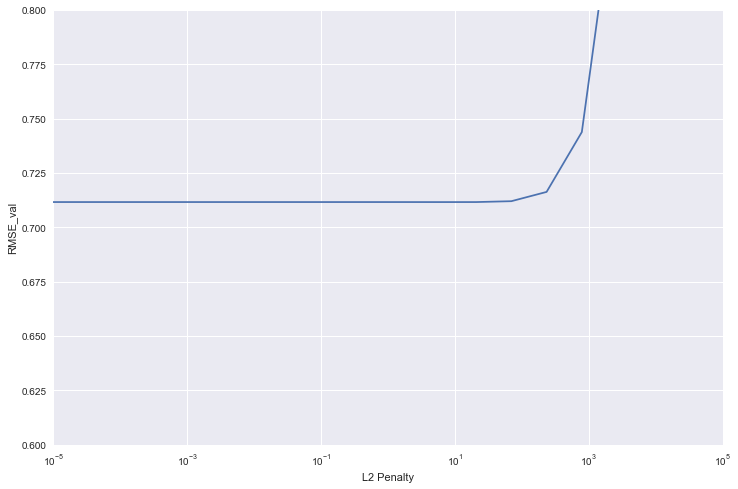

In [59]:
plt.figure(figsize=(12,8))
ax = plt.gca()
ax.plot(lamda, RMSE_val_set)
ax.set_xscale('log')
plt.xlabel('L2 Penalty')
plt.ylabel('RMSE_val')
plt.axis([min(lamda),max(lamda), 0.6, 0.8])

(3.1622776601683792e-06,
 316227.76601683791,
 -31303632554657800.0,
 29582423877707848.0)

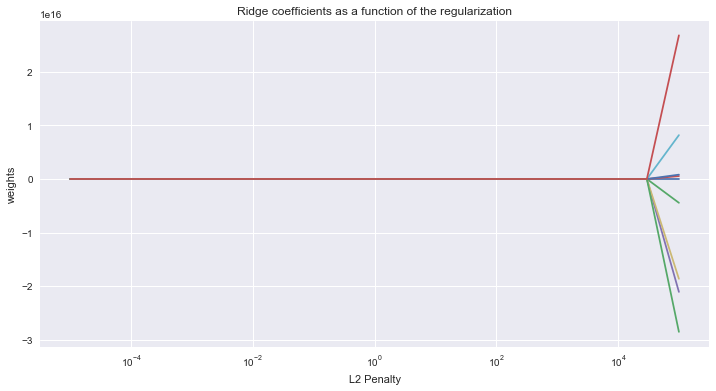

In [60]:
plt.figure(figsize=(12, 6))
ax = plt.gca()
ax.plot(lamda, coefs)
ax.set_xscale('log')
plt.xlabel('L2 Penalty')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')

Lamda is better in range 1e-5 to 1e2, I choose 1e-2 here


In [61]:
lr_33 = LR_L2_TF(alpha=0.1, n_iter=2000, lamda=0.01, printStep=200)
lr_33.fit(X_train, y_train)

Epoch 200 RMSE = 0.724096662467
Epoch 400 RMSE = 0.723846857003
Epoch 600 RMSE = 0.723845235747
Epoch 800 RMSE = 0.723845200932
Epoch 1000 RMSE = 0.723845200055
Epoch 1200 RMSE = 0.723845200023
Epoch 1400 RMSE = 0.72384520002
Epoch 1600 RMSE = 0.72384520002
Epoch 1800 RMSE = 0.72384520002
Epoch 2000 RMSE = 0.72384520002


In [62]:
RMSE_train = lr_33.myRMSE
RMSE_val = lr_33.getRMSE(X_val, y_val)
RMSE_test = lr_33.getRMSE(X_test, y_test)

print('RMSE_train:%f\nRMSE_val:%f\nRMSE_test:%f' % (RMSE_train, RMSE_val, RMSE_test))
print('Final Weights:\n', lr_33.getweights)

RMSE_train:0.723845
RMSE_val:0.711584
RMSE_test:0.744851
Final Weights:
 [[  2.06318138e+00]
 [  8.59124709e-01]
 [  1.21754757e-01]
 [ -3.03148452e-01]
 [  3.33293221e-01]
 [  6.31292652e-04]
 [ -4.98669206e-02]
 [ -8.93080956e-01]
 [ -8.66166807e-01]]


3.4 Fit the training data using regression model with lasso (L1 penalty) regularization using TensorFlow.


In [70]:
import tensorflow as tf

class LR_L1_TF(object): 
    
    def __init__(self, alpha=0.01, n_iter=10, lamda=0, printStep=10):
        self.alpha = alpha
        self.n_iter = n_iter
        self.lamda = lamda
        self.printStep = printStep
        self.scalar = StandardScaler()
           
    def fit(self, X, y):
        
        m, n = X.shape
        X_std = self.scalar.fit_transform(X) 
        X_scaled_bias = np.c_[np.ones((m, 1)), X_std]
          
        X = tf.constant(X_scaled_bias, dtype=tf.float64, name="X")
        y = tf.constant(y, dtype=tf.float64, name="y")
        self.weights = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=1, dtype=tf.float64), 
                                   name="weights")
        
        y_pred = tf.matmul(X, self.weights, name="predictions")
        error = y_pred - y
        RMSE = tf.sqrt(tf.reduce_mean(tf.square(error), name="mse"))
        gradients = 2/m * (tf.matmul(tf.transpose(X), error) + self.lamda/2)
        training_op = tf.assign(self.weights, self.weights - self.alpha * gradients)
        
        init = tf.global_variables_initializer()
        
        with tf.Session() as sess:
            sess.run(init)
        
            for epoch in range(self.n_iter):
                if (epoch+1) % self.printStep == 0:
                    print("Epoch", epoch + 1, "RMSE =", RMSE.eval())
                sess.run(training_op)
            self.getweights = self.weights.eval()
            self.myRMSE = RMSE.eval()
        sess.close() 
        
        return self
    
    def getRMSE(self, X, y):     
        X_std = self.scalar.transform(X) 
        X_std1 = np.c_[np.ones((X.shape[0], 1)), X_std]  
        
        X = tf.constant(X_std1, dtype=tf.float64, name="X")
        y = tf.constant(y, dtype=tf.float64, name="y")
        
        y_pred = tf.matmul(X, self.getweights)
        error = y_pred - y 
        RMSE = tf.sqrt(tf.reduce_mean(tf.square(error)))
        
        with tf.Session() as sess:
            haha = RMSE.eval()
        sess.close() 
        
        return haha
        

In [71]:
lamda = np.logspace(-5, 5, num=20)
coefs = []
RMSE_val_set = []
for i in range(len(lamda)):
    lr_34 = LR_L1_TF(alpha=0.1, n_iter=2000, lamda=lamda[i], printStep=5000)
    lr_34.fit(X_train, y_train)
    coefs.append(lr_34.getweights.reshape(-1))
    RMSE_val = lr_34.getRMSE(X_val, y_val)
    RMSE_val_set.append(RMSE_val)
    print('lamda: ', lamda[i], ' RMSE_val: ', RMSE_val)

lamda:  1e-05  RMSE_val:  0.711583611301
lamda:  3.35981828628e-05  RMSE_val:  0.711583611215
lamda:  0.000112883789168  RMSE_val:  0.711583610927
lamda:  0.000379269019073  RMSE_val:  0.71158360996
lamda:  0.0012742749857  RMSE_val:  0.711583606709
lamda:  0.00428133239872  RMSE_val:  0.711583595788
lamda:  0.0143844988829  RMSE_val:  0.711583559103
lamda:  0.0483293023857  RMSE_val:  0.711583435943
lamda:  0.162377673919  RMSE_val:  0.711583023209
lamda:  0.545559478117  RMSE_val:  0.711581648477
lamda:  1.83298071083  RMSE_val:  0.711577164843
lamda:  6.15848211066  RMSE_val:  0.711563627078
lamda:  20.6913808111  RMSE_val:  0.711535374901
lamda:  69.5192796178  RMSE_val:  0.711634987025
lamda:  233.572146909  RMSE_val:  0.714160928826
lamda:  784.759970351  RMSE_val:  0.746595122466
lamda:  2636.65089873  RMSE_val:  1.05585045957
lamda:  8858.6679041  RMSE_val:  2.73551472926
lamda:  29763.5144163  RMSE_val:  8.92328044194
lamda:  100000.0  RMSE_val:  29.9139888633


[1.0000000000000001e-05, 100000.0, 0.6, 0.8]

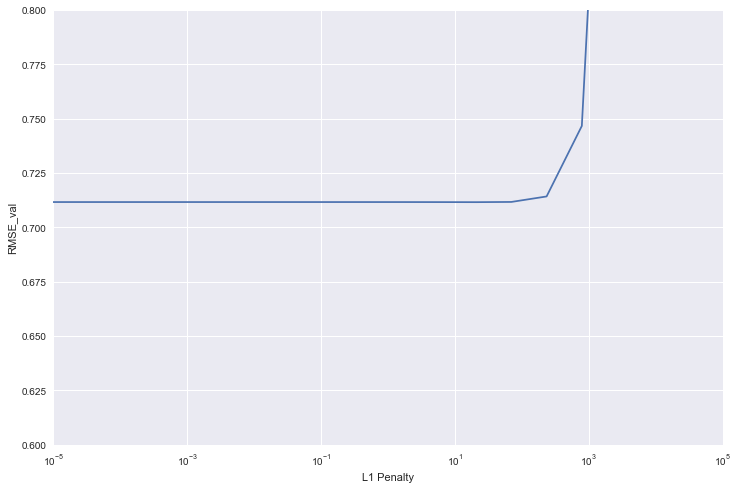

In [72]:
plt.figure(figsize=(12,8))
ax = plt.gca()
ax.plot(lamda, RMSE_val_set)
ax.set_xscale('log')
plt.xlabel('L1 Penalty')
plt.ylabel('RMSE_val')
plt.axis([min(lamda),max(lamda), 0.6, 0.8])

(3.1622776601683792e-06,
 316227.76601683791,
 -88.412018502941891,
 32.009065659101658)

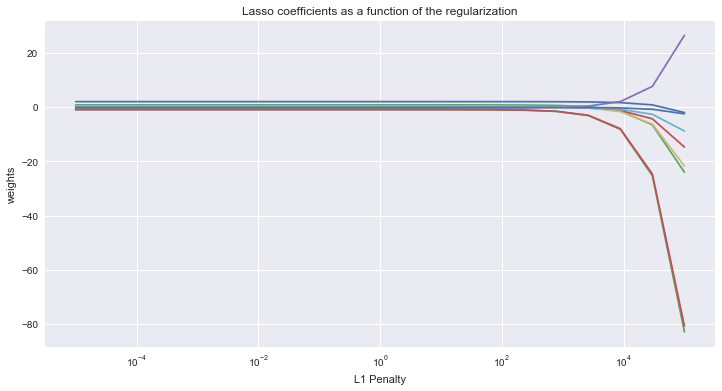

In [73]:
plt.figure(figsize=(12, 6))
ax = plt.gca()
ax.plot(lamda, coefs)
ax.set_xscale('log')
plt.xlabel('L1 Penalty')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization')
plt.axis('tight')

Lamda is better in range 1e-5 to 1e2, I choose 1e-2 here


In [74]:
lr_34 = LR_L1_TF(alpha=0.1, n_iter=2000, lamda=0.01, printStep=200)
lr_34.fit(X_train, y_train)

Epoch 200 RMSE = 0.724096531852
Epoch 400 RMSE = 0.72384684495
Epoch 600 RMSE = 0.723845234176
Epoch 800 RMSE = 0.723845200695
Epoch 1000 RMSE = 0.723845200012
Epoch 1200 RMSE = 0.72384520001
Epoch 1400 RMSE = 0.723845200012
Epoch 1600 RMSE = 0.723845200012
Epoch 1800 RMSE = 0.723845200012
Epoch 2000 RMSE = 0.723845200012


In [75]:
RMSE_train = lr_34.myRMSE
RMSE_val = lr_34.getRMSE(X_val, y_val)
RMSE_test = lr_34.getRMSE(X_test, y_test)

print('RMSE_train:%f\nRMSE_val:%f\nRMSE_test:%f' % (RMSE_train, RMSE_val, RMSE_test))
print('Final Weights:\n', lr_34.getweights)

RMSE_train:0.723845
RMSE_val:0.711584
RMSE_test:0.744851
Final Weights:
 [[  2.06318264e+00]
 [  8.59122866e-01]
 [  1.21752226e-01]
 [ -3.03147964e-01]
 [  3.33293989e-01]
 [  6.30063627e-04]
 [ -4.98671531e-02]
 [ -8.93099512e-01]
 [ -8.66185260e-01]]
